# <center>Data Science Project Part 2:  Fairness </center>
<center>DATA 558, Spring 2021</center>
<center>TAs: Alec Greaves-Tunnell and Ronak Mehta</center>


## Instructions

Welcome back to the DATA 558 project! Let's begin with a brief reminder of the format: each week, you will receive a notebook containing a data analysis involving the Animals with Attributes 2 (AwA2) dataset. The notebook will claim to meet some statistical or machine learning criterion relevant to the week's lecture topic. Your goal is to investigate and critique this analysis.

__Objective__: This notebook claims to implement a new method for classification of the AwA2 animals that is fair with respect to a given attribute. There are no mistakes in the syntax; each cell runs and returns a plausible result. However, there are several mistakes from a statistical and conceptual perspective. Working with your partner, you are expected to provide (1) a list of these mistakes and (2) a justification for why each item you list in (1) is a mistake. Justification can take many forms, including but not limited to a __detailed comment__, a __code example showing the problem__, or (perhaps simplest in some cases) a __direct fix of the code and demonstration that the problem is resolved__.


__Deliverable__: Please submit to Gradescope __a copy of this notebook with your findings and comments__. Please use the cell below to summarize the mistakes you found. That is, for each mistake, write a (short) indication of what the mistake is and where you found it. For every item in this summary, you are expected to provide a matching justification in the notebook with the same label - e.g. for mistake `A`, include in the notebook a justification (again, this may be a comment, code block, etc.) at the location where this mistake is made, also labeled `A`.



#### Name: Emily Yamauchi
#### Partner: Mayura Patwardhan
#### Summary of findings:

    DefinitelyFairModel:
    A: dfm.predict() --> Take test data vs train data

    B: equalized_odds_difference() --> Take test data vs train data
    
    C: Bigger picture:
    Separting out the protected features and training/predicting seperately does not achieve fairness under either demographic parity or equalized odds evaluation methods. We see that when the attribute=0, the model performs close to the naive model, but the attribute=1 model achieves near perfect prediction (cave is highly correlated with paws?).
    
    ...

In [1]:
import copy
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, plot_roc_curve, roc_auc_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split

from fairlearn.metrics import equalized_odds_difference, demographic_parity_difference

## Dataset: Animals with Attributes v2

The data consists of $n=5000$ examples from the `Animals with Attributes 2` dataset. In particular we have:

- $X \in \mathbb{R}^{n\times d}$, a $d=128$ dimensional random projection of the image data
- $Y \in \{0,1\}^n$, a binary label indicating whether the animal has the `paws` attribute
- $A \in \{0,1\}^n$, a binary label indicating whether the animal has the `cave` attribute

Our goal is to train a model to predict whether an animal has `paws` from the projected image data, in such a way that is fair with respect to whether or not the animal lives in a `cave`.

In [2]:
data = pickle.load(open("fairness_data.pkl", "rb"))

X = data['X']
y = data['y']
A = data['A']
A_str = pd.DataFrame(A)[0].map({0: 'No cave', 1: 'Cave'})

In [3]:
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, 
                                                                  y, 
                                                                  A, 
                                                                  test_size = 0.2, 
                                                                  random_state=12345,
                                                                  stratify=y)

The analysis you are expected to critique begins below.

## A first pass at fairness

You are joined on this project by a colleague, a budding machine learning scientist who dreams of developing the next great method in ML. After some initial data exploration, they report a simple finding:

In [4]:
pd.DataFrame(A_train).value_counts(normalize=True)

0    0.9345
1    0.0655
dtype: float64

In [5]:
df = pd.DataFrame(A_train)
print('0: ',df.loc[df[0] == 0].count()/len(df))
print('1: ',df.loc[df[0] == 1].count()/len(df))

0:  0    0.9345
dtype: float64
1:  0    0.0655
dtype: float64


"Hardly any animals in this dataset actually live in caves! I think we can do better if we focus the modeling effort on the non-cave animals. But don't worry, I also know how to make the model completely fair in terms of its predictions."

Some time later they return with the following implementation:

In [6]:
class FairClassifier:
    def __init__(self, clf):
        self.base_clf = clf
        
    def fit(self, X, y, A):
        counter = pd.DataFrame(A).value_counts()
        self.a = counter.index[0][counter.argmax()]
        self.maj_clf = self.base_clf.fit(X[A==self.a], y[A==self.a])
        self.pos_prob = np.mean(self.base_clf.predict(X[A==self.a]))
        
    def predict(self, X, A):
        preds = np.zeros(X.shape[0])
        preds[A==self.a] = self.base_clf.predict(X[A==self.a])
        preds[A!=self.a] = np.random.binomial(1, 
                                              self.pos_prob,
                                              size=len(preds[A!=self.a]))
        return preds

In [7]:
clf = DecisionTreeClassifier(max_depth=64)
fc = FairClassifier(clf)

fc.fit(X_train, y_train, A_train)

First, they demonstrate that the classifier achieves a satisfactory level of predictive accuracy:

In [8]:
preds = fc.predict(X_train, A_train)
r2_score(y_train, preds) 

0.8603447024299771

Next, they argue that the method is fair via the following analysis:

In [9]:
pos_rates = pd.DataFrame({a: [np.mean(preds[A_train==a])] for a in np.unique(A_train)})
pos_rates.columns = A_str.unique()
pos_rates.index = ['Prediction rate']
pos_rates

,No cave,Cave
Prediction rate,0.441413,0.480916


In [10]:
demographic_parity_difference(y_train, preds, sensitive_features=A_train)

0.03950351047014572

Are you impressed by the `FairClassifier` scheme?

## A new idea for fair classification

After a blissfully uninterrupted afternoon of data science, your colleague bursts back into your office with a new and improved method:

"It's obvious that the best way to achieve fairness is to fit a model to each group - by minimizing the train error for each group separately, we guarantee that each group gets the best performance possible!" 

In [11]:
class DefinitelyFairModel:
    def __init__(self, clf):
        self.base_clf = clf
        self.predictors = {}
        
    def fit(self, X, y, A):
        for a in np.unique(A):
            Xa = X[A==a]
            ya = y[A==a]
            clf = copy.copy(self.base_clf)
            self.predictors[a] = clf.fit(Xa, ya)
            
    def predict(self, X, A):
        preds = np.zeros(X.shape[0])
        for a in np.unique(A):
            preds[A==a] = self.predictors[a].predict(X[A==a])
        return preds
    
    def predict_proba(self, X, A):
        probs = np.zeros((X.shape[0], 2))
        for a in np.unique(A):
            probs[A==a] = self.predictors[a].predict_proba(X[A==a])
        return probs

##### Comment: 

DFM:   

Fits the model based on subset of X, y, A, for each attribute a in A.  
Using each model, then predicts values again based on the subset for each a in A.

Again, they claim that this new method demonstrates high accuracy. 

In [12]:
clf = LogisticRegression(C=1e-2, max_iter=250)

dfm = DefinitelyFairModel(clf)
dfm.fit(X_train, y_train, A_train)

In [13]:
preds = dfm.predict(X_train, A_train)
r2_score(y_train, preds)

0.8191514132186752

###### Comment:  

`dfm.predict()` should take X_test, A_test.

In [16]:
preds_fix = dfm.predict(X_test, A_test)
r2_score(y_test, preds_fix)

0.7548665027085243

And not only does it achieve high accuracy, but it also seems to have excellent performance on each subgroup:

In [17]:
def attr_ROC_curves(cls, X, A, Y, tau_range = np.linspace(0,1,51)):
    curves = {}
    all_probs = cls.predict_proba(X, A)[:, 1]
    for a in np.unique(A):
        curves[a] = []
        prob_a = all_probs[A==a]
        Ya = Y[A==a]
        for t in tau_range:
            pred = prob_a > t
            curves[a] += [(np.mean(pred[Ya==0]), np.mean(pred[Ya==1]))] 
    return tau_range, curves

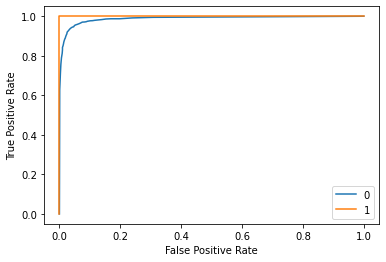

In [18]:
taus, roc = attr_ROC_curves(dfm, X_train, A_train, y_train)

for a in roc.keys():
    fp = [x[0] for x in roc[a]]
    tp = [x[1] for x in roc[a]]
    
    plt.plot(fp, tp, label=a)
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend();

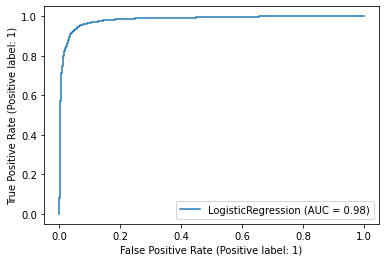

In [138]:
plot_roc_curve(base_m, X_train, y_train)

##### Comment: 

Attribution ROC curve for A=0 is similar to the ROC curve for the data. A=1 is a near perfect model. Reasoning.. is this because the model is trained/predicted seperately, and so it is overfitted for when A=1?

In [131]:
base_m = LogisticRegression().fit(X_train, y_train)

def attr_ROC_curves_base(cls, X, A, Y, tau_range = np.linspace(0,1,51)):
    ## <YOUR CODE HERE>
    res = {}
    all_probs = cls.predict_proba(X)[:, 1]
    for a in np.unique(A):
        res[a] = []
        prob_a = all_probs[A==a]
        Ya = Y[A==a]
        for t in tau_range:
            pred = prob_a > t
            res[a] += [(np.mean(pred[Ya==0]), np.mean(pred[Ya==1]))] 
    return tau_range, res



probs_base = base_m.predict_proba(X_train)[:,1] # probability belonging to class 1
tau_range = np.linspace(0,1,51)
res_base = {}
for a in np.unique(A_train):
    res_base[a] = []
    prob_a_base = probs_base[A_train==a]
    Ya_base = y_train[A_train==a]
    for t in tau_range:
        pred_base=prob_a_base > t # positive (meets threshold)
        res_base[a] += [(np.mean(pred_base[Ya_base==0]), np.mean(pred_base[Ya_base==1]))] #false- ya=0, true- ya=1

/home/eyamauchi/miniconda3/envs/DATA558/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


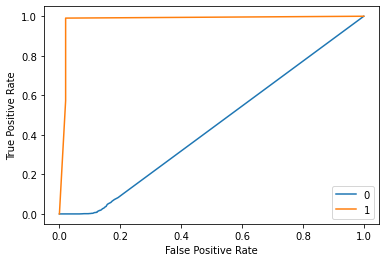

In [89]:
for a in res_base.keys():
    fp_base = [x[0] for x in res_base[a]]
    tp_base = [x[1] for x in res_base[a]]
    
    plt.plot(fp_base, tp_base, label=a)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend();

###### Comment: 

When evaluating base model (without training seperately for attributes), we see that A=1 is similarly near perfect prediction, whereas A=0 is close to random.

In [19]:
equalized_odds_difference(y_train, preds, sensitive_features=A_train)

0.054545454545454564

##### Comment:

`equalized_odds_difference()` should take testing, not training data.

In [97]:
equalized_odds_difference(y_test, preds_fix, sensitive_features=A_test)

0.05009633911368015

In [96]:
y_pred = base_m.predict(X_test)
equalized_odds_difference(y_test, y_pred, sensitive_features=A_test)

0.730836793356755

In [142]:
def demo_parity_table(preds, A):
    attr_probs = {a : preds[A==a].mean() for a in np.unique(A)}
    return pd.DataFrame({'P(f(X)=1 | A=a)': attr_probs, 'P(f(X)=1)' : preds.mean()}).T

def eq_odds_table(preds, A, Y):
    res = {}
    for a in np.unique(A):
        a_ix = A==a
        preds_a = preds[a_ix]
        Y_a = Y[a_ix]
        
        res[a] = {'TPR' : np.mean(Y_a * preds_a)/np.mean(Y_a),
                  'FPR': np.mean((1-Y_a)*preds_a)/np.mean(1-Y_a)}
    return pd.DataFrame(res)

In [146]:
demo_parity_table(preds, A_train)

,0,1
P(f(X)=1 | A=a),0.441413,0.812977
P(f(X)=1),0.465750,0.465750


In [147]:
eq_odds_table(preds, A_train, y_train)

,0,1
TPR,0.945455,1.0
FPR,0.043103,0.0


###### Comment:

The `DefinitelyFairModel` achieves neither demographic parity nor equalized odds.

What do you think of the `DefinitelyFairClassifier`?

In [134]:
n = 4000
d = 30

x_random = np.random.rand(n, d)
y_random = np.random.randint(2, size = n)
a_random = np.random.randint(2, size = n)


Xr_train, Xr_test, yr_train, yr_test, Ar_train, Ar_test = train_test_split(x_random, 
                                                                           y_random, 
                                                                           a_random, 
                                                                           test_size = 0.2, 
                                                                           random_state=12345,
                                                                           stratify=y_random)

In [135]:
m_random = LogisticRegression().fit(Xr_train, yr_train)
pred_random = m_random.predict(Xr_test)

tau_random, res_random = attr_ROC_curves_base(m_random, Xr_train, Ar_train, yr_train)

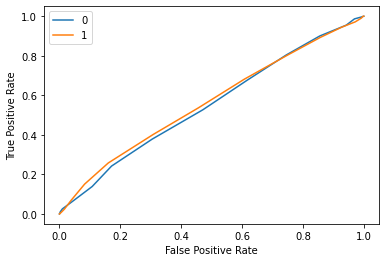

In [136]:
for a in res_random.keys():
    fp_rand = [x[0] for x in res_random[a]]
    tp_rand = [x[1] for x in res_random[a]]
    
    plt.plot(fp_rand, tp_rand, label=a)
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend();

In [141]:
equalized_odds_difference(yr_test, pred_random, sensitive_features = Ar_test)

0.07601112234580387

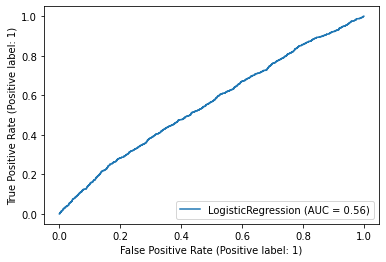

In [137]:
plot_roc_curve(m_random, Xr_train, yr_train)

## A new state-of-the-art method in fair ML?

Your colleague concludes with a final claim: "There's no way to train a logistic regression model that beats my `DefinitelyFairClassifier` - it dominates all the rest in terms of fairness and accuracy. I even went through the MSR `fairlearn` package, and their method doesn't even come close. I'm going to be up to my eyeballs in job offers with my new state-of-the-art method!"

They justify this claim with the following analysis:

In [ ]:
from fairlearn.reductions import GridSearch, EqualizedOdds

In [ ]:
model = LogisticRegression(C=1e-2, max_iter=250) # same base model as in `DefinitelyFairClassifier`

sweep = GridSearch(model,
                   constraints=EqualizedOdds(),
                   grid_size=7,
                  grid_limit=0.5)

sweep.fit(X_train, y_train, sensitive_features=A_train)

In [ ]:
# compute scores, predictions, and fairness / accuracy metrics for each model in the sweep
sweep_preds = [predictor.predict(X_train) for predictor in sweep.predictors_] 
sweep_scores = [predictor.predict_proba(X_train)[:, 1] for predictor in sweep.predictors_]

equalized_odds_sweep = [
    equalized_odds_difference(y_train, preds, sensitive_features=A_train)
    for preds in sweep_preds
]
auc_sweep = [roc_auc_score(y_train, scores) for scores in sweep_scores]

all_results = pd.DataFrame(
    {"predictor": sweep.predictors_, "accuracy": auc_sweep, "disparity": equalized_odds_sweep}
) 
non_dominated = [] 
for row in all_results.itertuples(): 
    accuracy_for_lower_or_eq_disparity = all_results["accuracy"][all_results["disparity"] <= row.disparity] 
    if row.accuracy >= accuracy_for_lower_or_eq_disparity.max(): 
        non_dominated.append(True)
    else:
        non_dominated.append(False)

equalized_odds_sweep_non_dominated = np.asarray(equalized_odds_sweep)[non_dominated]
auc_non_dominated = np.asarray(auc_sweep)[non_dominated]

In [ ]:
# get comparable results for the DFC
train_preds = dfm.predict(X_train, A_train)
train_scores = dfm.predict_proba(X_train, A_train)

dfm_auc = roc_auc_score(y_train, train_scores[:,1])
dfm_eod = equalized_odds_difference(y_train, train_preds, sensitive_features=A_train)

In [ ]:
# plot results 
plt.scatter(auc_non_dominated, equalized_odds_sweep_non_dominated, label="Grid Search Models")
plt.scatter(dfm_auc, dfm_eod, label="DefinitelyFair Model")

plt.xlabel("AUC")
plt.ylabel("Equalized Odds Difference")
plt.legend(bbox_to_anchor=(1.55, 1))
plt.xlim([0.97,1])
plt.xticks([1.0])
plt.show()